# Fitting data to a function

Fittings of data are not just restricted to polynomial models, that we already saw and that are implemented in *numpy* (*polyfit* function). In general, we could have models described by a given function $f(x; p)$, where $x$ is the *independent* variable and $p$ is a set of parameters, characterizing the model itself, that must be estimated by comparing the prediction of the model $y_c = f(x; p)$ to the $y_o$ *real* data. Generally one defines the squared difference $\epsilon=(y_c - y_o)^2$ (that is, the *the sum of the squared discrepancies* of the predictions of the model with respect to the real data) and determines the $p$'s by solving the equations $\partial\epsilon\ /\ \partial p_i=0$, for each parameter $p_i\in p$.

With this aim, we will use here the function *curve_fit* from the *scipy.optimize* library. 

The game is to get data of specific heat (at constant volume) of pyrope, in a given temperature ($T$) range, and to fit the data as a function of $T$ by using the *einstein* model (with one or two *Einstein's temperatures*). Such Einstein temperature(s) is (are) the parameter(s) of the model. The model itself is the function (written below for just one parameter $\theta$):

$$C_v(T) = n{\cal N}k_B \left(\dfrac{\theta}{T}\right)^2 \dfrac{e^{\theta/T}}{\left(e^{\theta/T} -1\right)^2}$$

where $n$ in the *number of atoms per formula unit*; ${\cal N}$ is the *Avogadro* number and $k_B$ is the Boltzmann's constant.

To plot data, we will also make use of a *plot* module.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy.optimize import curve_fit
from functools import partial
import plot 

The class written in the following cell defines the functions of the models (one or two parameters models). 

Note that the *number of atom per formula unit* must be provided for the considered substance; this is not that *satisfactory* as the class is intended to deal with just the model functions, but it is implemented in a way that contains an attribute ($n$: *apfu*) referring to a specific substance... think about that...    

In [2]:
class Einstein():
    def __init__(self, apfu):
        self.apfu=apfu
        self.avo=6.02214179e+23
        self.kb=1.3806505e-23
        
    def set_apfu(self, apfu):
        self.apfu=apfu

# One parameter Einstein function    
    def einstein_fun(self, tt, eps):    
        return self.apfu*3*self.avo*self.kb*((eps/tt)**2)*np.exp(eps/tt)/((np.exp(eps/tt)-1)**2)

# Two parameters Einstein function
    def einstein_2_fun(self,tt,eps1,eps2):
        f1=self.apfu*3*self.avo*self.kb/2.
        f2=((eps1/tt)**2)*np.exp(eps1/tt)/((np.exp(eps1/tt)-1)**2)
        f3=((eps2/tt)**2)*np.exp(eps2/tt)/((np.exp(eps2/tt)-1)**2)
        return f1*(f2+f3)

In the following cell we define the instance *ein* of the *Einstein class* and also the instance *my_plot* of the *plot class*.

Then, data (temperature and specific heat) will be read from a file sitting in the *data_files* folder

In [3]:
my_plot=plot.plot_class('data_files')

# define ein as an instance of the class
# Einstein, by also setting the apfu 
# attribute to 20
ein=Einstein(20)

data=np.loadtxt('data_files/cv_data.dat')
temp=data[:,0]
cv=data[:,1]

Wanting to fit in temperature ranges different from the one in the data file, here we define the *data_limit* function to select data in the appropriate temperature range.

Then we define the *einstein_fit* function which will do all of the work... 

In [4]:
def data_limit(tmin=0., tmax=np.max(temp)):
    select=(temp >= tmin) & (temp <= tmax)
    t_list=temp[select]
    cv_list=cv[select]
    
    return t_list, cv_list

def einstein_fit(tmin=10., tmax=np.max(temp), fix=200., guess=50., bounds=(10., 2500.), npoints=100):
    
    t_list, cv_list=data_limit(tmin, tmax)
    
# Initial guess for the parameters (one and two-parameter models)
    guess1=[guess]
    guess2=[guess, guess]

# curve_fit function    
    ein_fit1, ein_cov1=curve_fit(ein.einstein_fun, t_list, cv_list, bounds=bounds,\
                      p0=guess1, xtol=1e-15, ftol=1e-15)
    ein_fit2, ein_cov2=curve_fit(ein.einstein_2_fun, t_list, cv_list, bounds=bounds,\
                      p0=guess2, xtol=1e-15, ftol=1e-15)
    
    fixed_fun=partial(ein.einstein_2_fun, eps2=fix)
    ein_fix, ein_fix_cov=curve_fit(fixed_fun, t_list, cv_list, bounds=bounds,\
                                  p0=guess1, xtol=1e-15, ftol=1e-15)
    
    print("Einstein temperature(s)\n")
    print("1 temperature model:  %5.1f (K)" % ein_fit1[0])
    print("2 temperatures model: %5.1f, %5.1f (K)" % (ein_fit2[0], ein_fit2[1]))
    print("2 temperatures 'fixed' model: %5.1f, %5.1f (K)\n" % (fix, ein_fix[0]))
    
    model1=np.array([ein.einstein_fun(it, *ein_fit1) for it in t_list])
    model2=np.array([ein.einstein_2_fun(it, *ein_fit2) for it in t_list])
    model3=np.array([fixed_fun(it, ein_fix, eps2=fix)[0] for it in t_list])
    
    serie=[t_list, cv_list, model1.round(2), model2.round(2), model3.round(2)]
    df=pd.DataFrame(serie, index=['T  ', '   Cv Exp', ' model 1', ' model 2', ' model 3'])
    df=df.T
    print(df.to_string(index=False), '\n')  
       
    t_plot=np.linspace(tmin, tmax, npoints)
    cv1_plot=np.array([ein.einstein_fun(it, *ein_fit1) for it in t_plot])
    cv2_plot=np.array([ein.einstein_2_fun(it, *ein_fit2) for it in t_plot])
    cv3_plot=np.array([fixed_fun(it, ein_fix, eps2=fix)[0] for it in t_plot])
        
    x=[t_list, t_plot, t_plot, t_plot]
    y=[cv_list, cv1_plot, cv2_plot, cv3_plot]
    style=['k*', 'k--', 'k-', 'k-.']
    label=['Actual values', '1p fit', '2p fit','2pf fit']
    
    my_plot.set_param(tex=True, fsize=16, tsize=14, dpi=200)
    my_plot.multi(x,y,style, label, xlab=r'$T (K)$', ylab=r'$C_v (J/mol\ J)$', figsize=(5,3), save=True)

The *curve_fit* function accepts:

- the name of the model function (*ein.einstein_fun* or *ein.einstein_2_fun*);
- the independent variable *t_list*;
- the dependent variable *cv_list* (against which the fit must be done);
- the *bounds* (if any) within which the parameters should be contained; this is an optional keyword argument to *curve_fit*; in this specific case it is provided as a keyword argument of the *einstein_fit* function;
- guess value(s) as keyword argument *p0* from which the fit starts;
- *xtol* and *ftol*: optional keyword values controlling tolerances for the fit.

In the code above, note the use of the function *partial* from the library *functools* (imported in a previous cell): this is needed if you want to keep *constant* the argument of a given function that was previously defined. For instance:

In [5]:
# define f as a two-argument function 
def f(x,a):
    return x**a

# define the function g starting from f
# and transform the second argument of f
# in a constant parameter
g=partial(f, a=3)

print("f(2, 3): ", f(2,3))
print("g(2):    ", g(2))

f(2, 3):  8
g(2):     8


In the context of the *einstein_fit* function, the *partial* function is used to make a fit to the two-parameter Einstein function, where one of the parameters is fixed to some definite value (*fix*).

In the following cell we run the *einstein_fit* function with *fix*=400, and the other keyword parameters set to their default values:

Einstein temperature(s)

1 temperature model:  633.4 (K)
2 temperatures model: 1017.9, 341.5 (K)
2 temperatures 'fixed' model: 400.0, 956.0 (K)

  T       Cv Exp   model 1   model 2   model 3
 20.0       4.37      0.00      0.00      0.00
 56.0      31.53      0.78     20.95     10.08
 92.0      85.15     24.25     88.72     63.43
127.0     141.41     85.85    146.39    123.40
163.0     193.78    161.22    194.16    179.01
199.0     238.55    228.10    235.96    228.00
235.0     276.19    281.44    273.00    270.13
271.0     307.68    322.55    305.14    305.46
306.0     333.31    353.28    331.75    333.89
342.0     355.39    377.77    354.78    357.92
378.0     373.85    396.88    374.00    377.61
414.0     389.33    411.98    390.02    393.79
449.0     402.00    423.77    403.07    406.82
485.0     413.02    433.63    414.37    418.00
521.0     422.34    441.72    423.91    427.36
557.0     430.27    448.42    432.00    435.25
593.0     437.06    454.03    438.91    441.96
628.0    

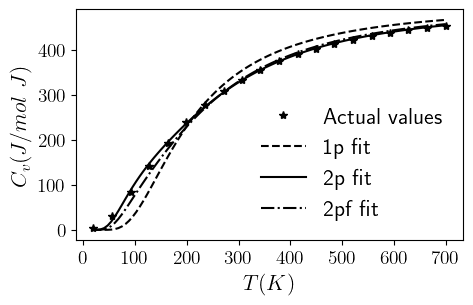

In [6]:
einstein_fit(tmin=20, fix=400.)

Here we rerun the fit by changing the interval of temperatures considered: 

Einstein temperature(s)

1 temperature model:  716.9 (K)
2 temperatures model: 258.9, 1066.9 (K)
2 temperatures 'fixed' model: 200.0, 1091.0 (K)

  T       Cv Exp   model 1   model 2   model 3
306.0     333.31    321.88    333.82    335.74
342.0     355.39    350.26    355.23    356.12
378.0     373.85    372.81    373.46    373.72
414.0     389.33    390.88    388.91    388.77
449.0     402.00    405.14    401.65    401.28
485.0     413.02    417.15    412.79    412.27
521.0     422.34    427.08    422.26    421.66
557.0     430.27    435.35    430.35    429.71
593.0     437.06    442.30    437.29    436.64
628.0     442.75    448.04    443.13    442.48
664.0     447.85    453.10    448.34    447.71
700.0     452.32    457.46    452.89    452.28 



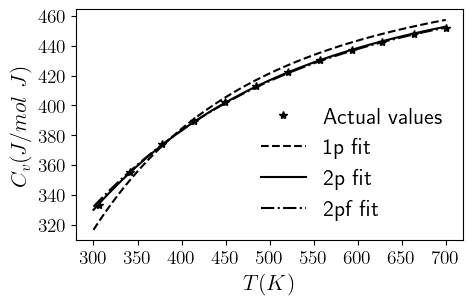

In [7]:
einstein_fit(tmin=300)

Results of the fits (optimized parameters; error of the fit; covariance matrix and other information) are stored in *local* variables of the function *einstein_fit* and, therefore, are no longer available as the function ends. This not a good feature of the implementation proposed above.

Moreover, the function *einstein_fit* definitely does too much things at the same time: the code is not structured (it has to deal with the preparation of the data; with the set up of the fits and their execution; with the presentation of results).

The arguments required the run such *einstein_fit* function are too many and, more than that, their are not *logically* related: some of them have to do with the data (*tmin*, *tmax*); some other parameters deal with the fit quality and control (*guess*, *bounds*); *fix* has to do with the parameter being fixed during the fit and, finally, *npoints* has to do with the plotting section... that's a mess!  

As a rule of thumb, a function 
- should accept no more than 3 arguments (4 at most);
- it must be very well structured and do just few things at the same time (by somehow *delegating* to other functions a number of *subtasks*);
- it should be easily readible so that its structure, purpose and methods do emerge at a first glance and do not require much effort by the reader to figure out their meanings.  